# Appendix D2: Stochastic and periodic noise
**Appendix D discusses remaining noise and errors**

In this notebook we take a brief look at stochastic noise.
This type of noise is a _much bigger issue_ for single channel measurements, and much more thorough explorations of noise can be found e.g. in [Sigworth 1995](https://doi.org/10.1007/978-1-4419-1229-9_4), [Benndorf 1995](https://doi.org/10.1007/978-1-4419-1229-9_5), or the [Axon Guide](https://www.moleculardevices.com/en/assets/ebook/dd/cns/axon-guide-to-electrophysiology-and-biophysics-laboratory-techniques).

Reducing noise is also a major point of interest, but will not be discussed in this notebook.
Instead, we have a quick look at the stochastic and periodic noise we might see in a manual whole-cell patch experiment, and discuss how this relates to uncertainty quantification.

## Stochastic noise

We'll start by looking at stochastic noise, using the model:

\begin{equation}
I_\text{measured} = I_\text{ion} + I_\text{stochastic} = I_\text{ion} + \mathcal{N}(0, \sigma)
\end{equation}

This assumes that
- the noise is purely _additive_, and does not affect $I_\text{ion}$ or $I_\text{measured}$ in more complicated ways.
- the noise in sample $I_\text{measured}[i]$ is independent of the noise at $I_\text{measured}[i-1]$, or at any previous sample $I_\text{measured}[j < i]$.
- the noise follows a normal distribution with mean zero and a constant standard deviation $\sigma$.

This model can be used for noise that is truly stochastic, but perhaps also for processes that change quickly enough to _look_ stochastic, given our sampling rate.
Noise that _more or less_ matches these assumptions can arise from from the electronics e.g. [thermal noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise), and [shot noise](https://en.wikipedia.org/wiki/Shot_noise).
We can even expect some fluctuations from the stochastic opening and closing of the channels themselves: a 1973 paper by [Anderson and Stevens](https://doi.org/10.1113/jphysiol.1973.sp010410) showed that "channel noise" with a high enough amplitude can be analysed to estimate the number of channels in a cell.

It can be worthwhile to examine these assumptions, for example by looking at a "boring" part of an experimental result, where the voltage is stable and the channels are assumed to be in or near their steady state.

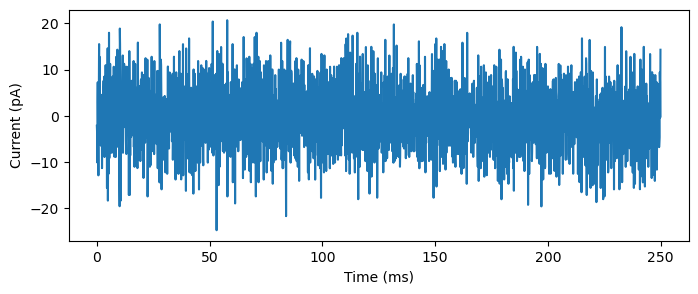

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints
import scipy.stats

# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('./resources/sine-wave-data/cell-1.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

plt.figure(figsize=(8, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(log.time(), log['current'] * 1000)  # Convert from nA to pA
plt.show()

We can try and visually inspect this data, for example to see how it compares to a normal distribution:

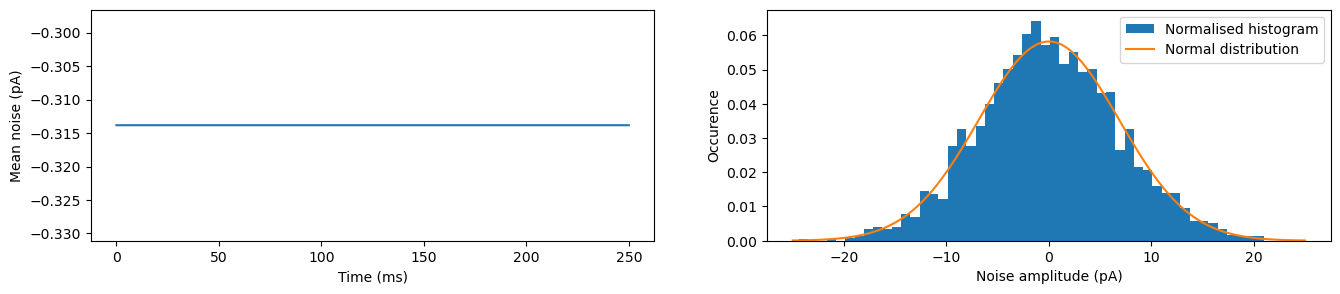

In [3]:
# Subtract the mean and show a histogram of this noise:

noise = log['current'] * 1000 # Convert from nA to pA
offset = np.mean(noise)
variation = noise - offset

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Mean noise (pA)')
ax.plot(log.time(), np.ones(noise.shape) * offset)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Noise amplitude (pA)')
ax.set_ylabel('Occurence')
ax.hist(variation, bins=50, density=True, label='Normalised histogram')

x = np.linspace(-25, 25, 100)
ax.plot(x, scipy.stats.norm.pdf(x, 0, np.std(variation)), label='Normal distribution')
ax.legend()

plt.show()

So the data _looks_ to be normally distributed, although not with a zero offset (more about that later).
More rigorous tests of normality are available, but for large sample sizes like these, they tend to be _too strict_, and reject the hypothesis that the distribution is normal, for even very minor deviations from normality.

Another thing we can investigate is whether the noise in this cell was [_independent and identically distributed_ (iid)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables).
A quick visual way to do this is to make a plot of the _autocorrelation_, which shows you how much the points at any index $i$ correlate with the points at $i - \text{lag}$.
For $\text{lag} = 0$ this is $1$ by definition, but for higher lags this should be close to zero if the noise is iid.
One rule of thumb is to plot the lines at $\pm1.96 \sqrt{n}$, which corresponds to the 95% confidence interval, and then check that only 5% of the autocorrelations are outside this interval.

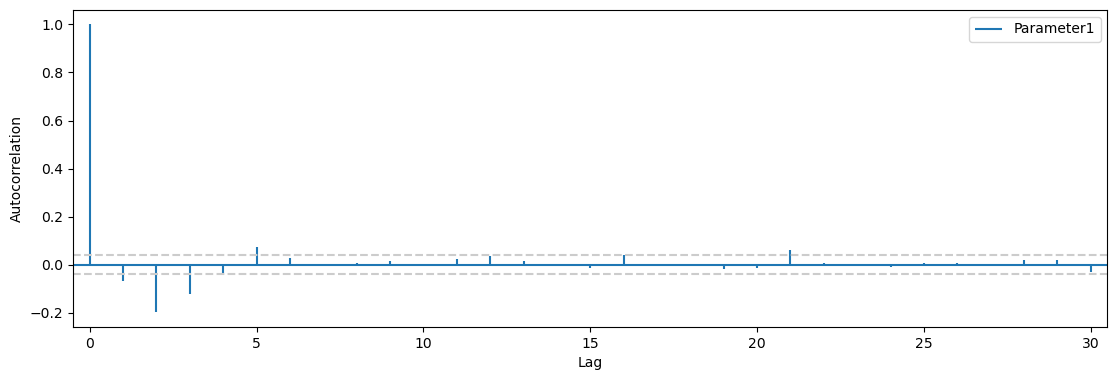

In [4]:
import pints.plot

# pints.plot.autocorrelation expects an array of shape (n_samples, n_parameters)
# See: https://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation
n = len(variation)
reshaped = variation.reshape((n, 1))

fig, ax = pints.plot.autocorrelation(reshaped, max_lags=30)
fig.set_size_inches(12, 5)
ax[0].axhline(+1.96 / np.sqrt(n), ls='--', color='#cccccc')
ax[0].axhline(-1.96 / np.sqrt(n), ls='--', color='#cccccc')
plt.show()

So it looks like our noise is fairly independent!

Now that we now this, how it help us deal with noise?
Because the noise is stochastic, we can't model it directly and subtract it from our recordings.
But we _can_ write a statistical model for our noise, and fit that to the data.

First, we assume that at any point intime the measured current $I_\text{measured}(t)$ can be modelled as the sum of a current model $m(t|p)$ with parameters $p$ and a random variable from a normal distribution with standard deviation $\sigma$:

\begin{equation}
I_\text{measured}(t) = m(t|p) + \mathcal{N}(0, \sigma)
\end{equation}

In the ["basic fitting"](basic-fitting.ipynb) notebook, we saw that this lets us write a _probability density function_ $f$ for obtaining a certain measurement _given_ a fixed $p$ and $\sigma$, and that this could be used to define a _log-likelhood_ for $p$ and $\sigma$ given a particular measurement $D$:

\begin{equation}
\log l(p, \sigma|D) = -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i = 1}^{N} \left(I_\text{measured}(t_i) - m(t_i|p)\right)^2
\end{equation}

where $D$ is a digitised set of measurements $D = \{(t_1, I_\text{measured}(t_1)), (t_2, I_\text{measured}(t_2)), ..., (t_N, I_\text{measured}(t_N))\}$.

In the basic fitting tutorial we observed that for a fixed value of $\sigma$ the process of _maximising this log-likelihood_ is the same as _minimising the sum of squared errors_ $I_\text{measured}(t_i) - m(t_i|p)$, and we proceeded using this approach in most of the tutorial.

However, instead of passing in an [ErrorMeasure](https://pints.readthedocs.io/en/latest/error_measures.html), PINTS optimisers can also operate directly on a [LogLikelihood object](https://pints.readthedocs.io/en/latest/log_likelihoods.html):

In [12]:
import myokit.lib.hh

class ModelHHSolver(pints.ForwardModel):
    """
    A forward model that runs simulations on step protocols, using an
    analytical solving method for Hodgkin-Huxley models.
    """

    def __init__(self, protocol):

        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('./resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]
        hh_model = myokit.lib.hh.HHModel.from_component(
            model.get('ikr'), parameters=parameters)

        # Create an analytical simulation
        self.sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)

        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))

    def n_parameters(self):
        return 9

    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        self.sim.set_parameters(parameters)
        tmax = times[-1] + (times[-1] - times[-2])
        log = self.sim.run(tmax, log_times=times)
        return log['ikr.IKr']

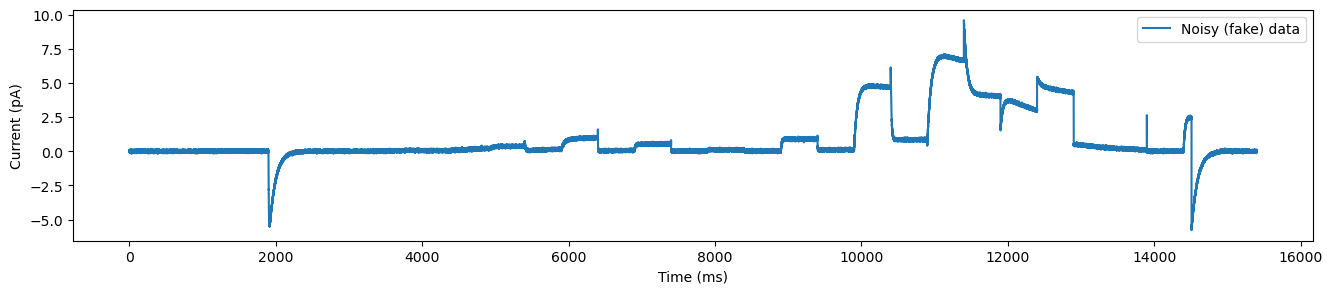

In [13]:
# Set up a simple fitting problem
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

protocol = myokit.load_protocol('./resources/simplified-staircase.mmt')
model = ModelHHSolver(protocol)
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.05, times.shape)
problem = pints.SingleOutputProblem(model, times, values)

plt.figure(figsize=(16, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy (fake) data')
plt.legend()
plt.show()

Next, we isolate a bit of noise from the start of the signal to estimate sigma:

In [14]:
noise = values[:1000]
sigma = np.std(noise)
print('Estimated sigma: ' + str(sigma))

Estimated sigma: 0.049523745214049855


And we use this to create and maximise a [pints.GaussianKnownSigmaLogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html#pints.GaussianKnownSigmaLogLikelihood):

In [15]:
# Create a log-likelihood object
log_pdf = pints.GaussianKnownSigmaLogLikelihood(problem, sigma)

# Choose a slightly random starting point
x0 = parameters * 2**np.random.normal(0, 0.25, parameters.shape)

# Use an optimiser to maximise it
opt = pints.OptimisationController(log_pdf, x0)
opt.set_log_to_screen(False)
xopt, fopt = opt.run()

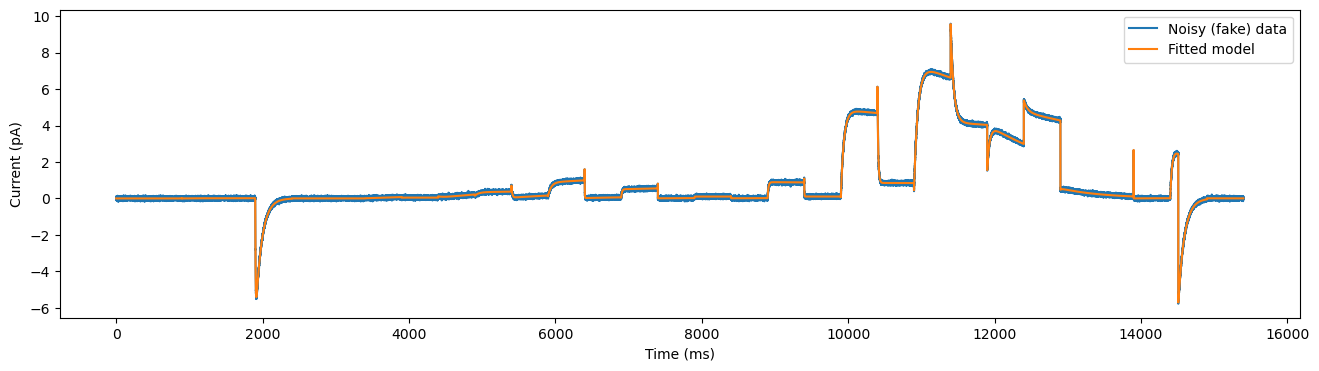

In [16]:
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy (fake) data')
plt.plot(times, problem.evaluate(xopt), label='Fitted model')
plt.legend()
plt.show()

Here we followed a two-step process, first estimating sigma from a small chunk of the data and then using this estimate to do the full fit.
But there's nothing stopping us from inferring $\sigma$ along with the rest of the parameters!

In [17]:
# Create an unknown sigma log-likelihood object
log_pdf = pints.GaussianLogLikelihood(problem)

# This log likelihood has one more parameter than our model!
print(model.n_parameters())
print(log_pdf.n_parameters())

9
10


As before, we can use an optimiser to maximise this log-likelihood, but now we need to pass in a starting point that also includes an estimate for sigma:

In [18]:
x0_with_sigma = np.concatenate((x0, [0.3]))

opt = pints.OptimisationController(log_pdf, x0_with_sigma)
opt.set_log_to_screen(False)
xopt, fopt = opt.run()

Now the returned parameter vector includes an extra value for the estimated sigma:

In [19]:
print('Estimated sigma: ' + str(xopt[-1]))

Estimated sigma: 0.050034846288405814


This probabilistic approach opens up new possibilities for investigation.
For example, we could replace the assumption of iid noise with the assumption that the noise is correlated and would be better described by an [Autoregressive AR1 model](https://en.wikipedia.org/wiki/Autoregressive_model).
We can then replace our Gaussian loglikelihood by a [pints.AR1LogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html#pints.AR1LogLikelihood) and compare the quality of fit.

Instead of finding the maximum of the proposed likelihood function, we can also use [sampling methods](https://pints.readthedocs.io/en/latest/mcmc_samplers/index.html) to explore the full distribution.
If the model fits the data extremely well, this can provide an estimate of the uncertainty in the obtained parameters.
However, if there is a slight _discrepancy_ between the final model predictions and the experimental recording (as is typically the case in ion current electrophysiology), the results of applying a sampling method are much harder to interpret.

## Periodic noise

In addition to stochastic (additive) noise, we might also look for periodic noise.
An easy way to spot this is by creating and plotting an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) or [power spectrum](https://en.wikipedia.org/wiki/Spectral_density).

We start by defining a quick function to calculate a power spectrum:

In [20]:
def spectrum( times, current):
    """
    Calculates the power spectrum (or spectral density) of a (regularly spaced)
    time series ``(times, current)``, and returns a tuple ``(freq, power)``
    where ``freq`` contains a list of positive frequencies, and ``power``
    is the associated spectral density (if current is in "units", the power will
    be unit "units**2").
    """
    # Import fft functions
    try:
        # Latest scipy
        from scipy.fft import fft, fftshift, fftfreq
    except ImportError:
        from scipy.fftpack import fft, fftshift, fftfreq
    
    # Length of time series (assuming len(times) == len(current))
    n = len(times)
    
    # Time-step (assuming points are equally spaced)
    dt = times[1] - times[0]
           
    # Points in the FFT
    points = fftshift(fft(current)).real
    
    # Frequency of points in the fft
    frequency = fftshift(fftfreq(n, dt))
    
    # Select positive points
    positive = frequency > 0
    
    return frequency[positive], points[positive]**2


Using this function, we can have a look at the start of Cell 1's data again:

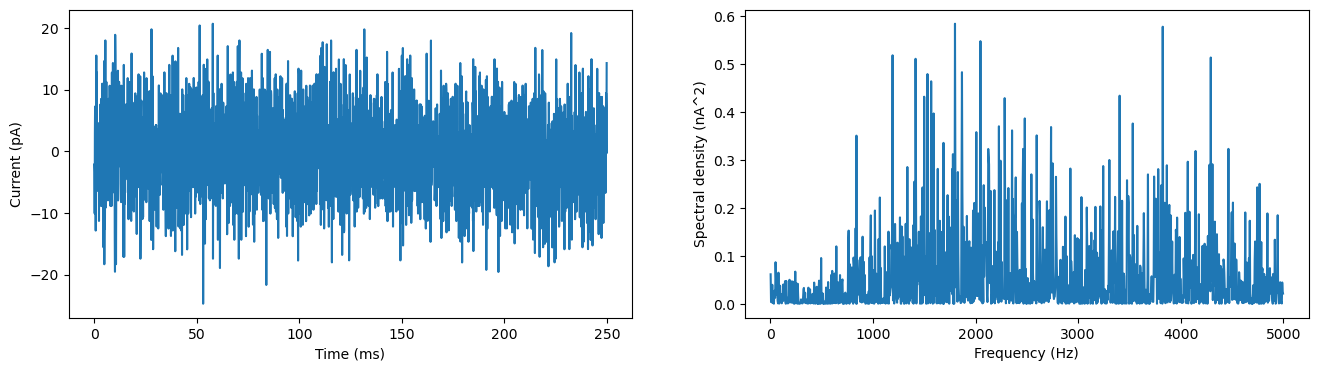

In [21]:
# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('./resources/sine-wave-data/cell-1.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

# Calculate the power spectrum
times = log.time()
current = log['current']
freq, points = spectrum(times * 1e-3, current)  # Using time in seconds to get frequency in Hz

# Show the results
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(times, current * 1e3)  # Convert from nA to pA

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)

plt.show()

So it looks like there's no particular frequencies that dominate the noise in this recording.

Because we recorded at a sample spacing of $0.1\text{ms} = 10^{-4}\text{s}$, the highest frequency observable in the signal is half the sampling rate, so $\frac{1}{2} 1 / 10^{-4}\text{s} = \frac{1}{2} 10\text{kHz} = 5\text{kHz}$.
Notice that the [Nyquist-Shannon sampling theory](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) says something stronger than that; it says that _even lower frequency signals_ can't be reconstructed from a digital recording if frequencies higher than half the sampling rate are present in the signal.
A common way to ensure this is the case, is to use low-pass filtering before digitisation (so this is an example of online filtering that we cannot escape!).
Looking at the [published raw data files](https://figshare.com/articles/Sinusoidal_voltage_protocols_for_rapid_characterization_of_ion_channel_kinetics_supplementary_experimental_data/4702546/1) for this study, we can inspect the meta data (e.g. using [Myokit's DataLog viewer](https://myokit.readthedocs.io/cmd/log.html)) and see that this signal was indeed low-pass filtered at 5kHz before digitisation.

Now let's look at a different recording:

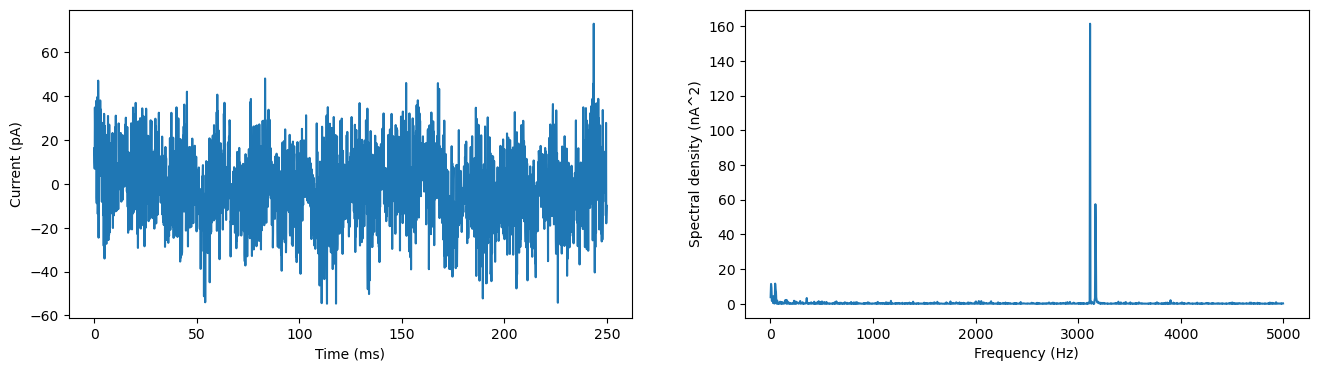

In [22]:
# Load Cell 7 from Beattie et al.
log = myokit.DataLog.load('./resources/sine-wave-data/cell-7.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

# Calculate the power spectrum
times = log.time()
current = log['current']
freq, points = spectrum(times * 1e-3, current)  # Using time in seconds to get frequency in Hz

# Show the results
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(times, current * 1e3)  # Convert from nA to pA

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)

plt.show()

This shows some very different characteristics!

In the power spectrum plot on the right, we can clearly see two peaks around $3.2 \text{kHz}$.
These are most likely from some piece of electronic equipment in the same room or, if the noise is transmitted through the mains or the grounding, somewhere else in the building!

In the direct plot on the left, we can also see what look like some lower frequency periodic effects.
We can do a few zoomed plots to get a clearer picture:

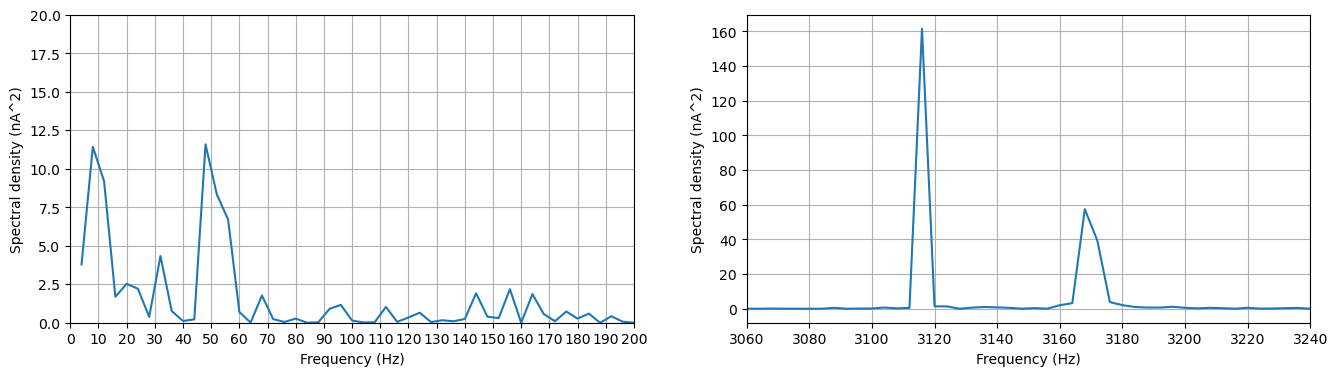

In [23]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)
ax.set_xlim(0, 200)
ax.set_ylim(0, 20)
ax.set_xticks(np.arange(0, 210, 10))
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)
ax.set_xlim(3060, 3240)
ax.set_xticks(np.arange(3060, 3260, 20))
ax.grid(True)

plt.show()

Starting on the right again, we see two large peaks at around $3115 \text{Hz}$ and $3170 \text{Hz}$.
If we assume this noise is from something man-made, we might expect the frequencies to be nice round numbers, so it can be worth googling our frequency estimates to see if anyone knows what's causing them!
Judging from the fact that we see these clear signals in cell 7, but not cell 1, we might suspect it's something that gets switched on and off during the day, but it could also come from something like a fridge which switches itself on from time to time.

On the left, we see a peak of unknown origins at $10 \text{Hz}$, but also one at $50 \text{Hz}$, which is a clear example of ["mains hum"](https://en.wikipedia.org/wiki/Mains_hum).

So how do we use this knowledge?

One option, especially when the peaks are as sharp as shown above, is to digitally filter out one of the frequencies.
We could also try fitting sine waves and subtracting them from the signal, or including the sine waves in our (noise) model.
But we could also observe that the strongest peaks are of a much higher frequency than what we expect from the current of interest, and that the lower frequency peaks are quite small.
So it might be fine to just leave the noise in, avoiding the risk of our "corrections" making things worse, and to present the data to our optimisation routine as-is.
Zooming out and observing the whole signal, this doesn't seem too bad an idea, and indeed this is the approach we took in e.g. [Four ways to fit an ion channel model](https://doi.org/10.1016/j.bpj.2019.08.001).

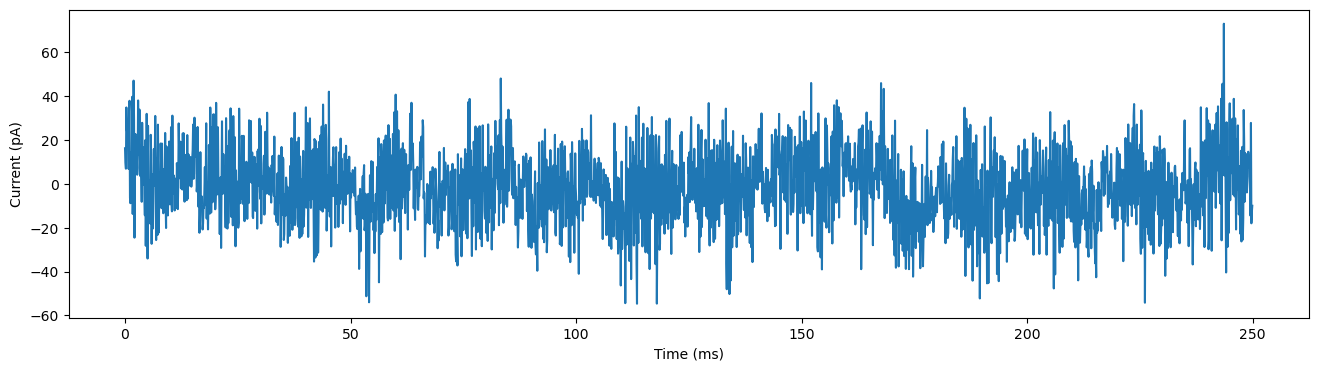

In [24]:
# The full signal for cell 7
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(log.time(), log['current'] * 1e3)
plt.show()

## Uncertainty quantification and model discrepancy

It's quite tempting to use noise models as shown above to defined a likelihood function, explore it with uncertainty quantification (UQ) methods such as [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), _and then to interpret the result as information about the certainty of our inferred parameters_.

This works well if there is no _model discrepancy_. In other words, if the model is able to draw a line through the data perfectly, such that all deviations from this line can be attributed to stochastic (or periodic) noise, then we can use UQ to investigate the uncertainty in our parameter estimates due to that noise.

However, in many cases the mismatch between the best-fit model and the data does not look like it was generated by an additive stochastic (or periodic) noise model.
To illustrate this, we look at the Cell 1 data again, and superimpose a simulated result with parameters obtained from a fitting experiment.

In [25]:
# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('./resources/sine-wave-data/cell-1.zip').npview()

In [26]:
# Load the model
model = myokit.load_model('./resources/beattie-2017-ikr-hh.mmt')

# Load the steps in the sine wave protocol
protocol = myokit.load_protocol('./resources/sine-wave-steps.mmt')

# Update the model to add in sine waves
c = model.get('membrane')
v = c.get('V')
v.set_binding(None)
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')
model.get('membrane.V').set_rhs(
    'if(engine.time >= 3000.1 and engine.time < 6500.1,'
    + ' - 30'
    + ' + 54 * sin(0.007 * (engine.time - 2500.1))'
    + ' + 26 * sin(0.037 * (engine.time - 2500.1))'
    + ' + 10 * sin(0.190 * (engine.time - 2500.1))'
    + ', vp)')

# Create simulation
sim = myokit.Simulation(model, protocol)

In [27]:
# Simulate using the parameters from Beattie et al.
p = {
    'ikr.p1': 1.98e-4,
    'ikr.p2': 0.0593,
    'ikr.p3': 7.1688e-5,
    'ikr.p5': 0.0493,
    'ikr.p5': 0.1048,
    'ikr.p6': 0.0139,
    'ikr.p7': 0.0038,
    'ikr.p8': 0.036,
    'ikr.p9': 0.1351,    
}
for k, v in p.items():
    sim.set_constant(k, v)
d = sim.run(8001, log_times=log.time())

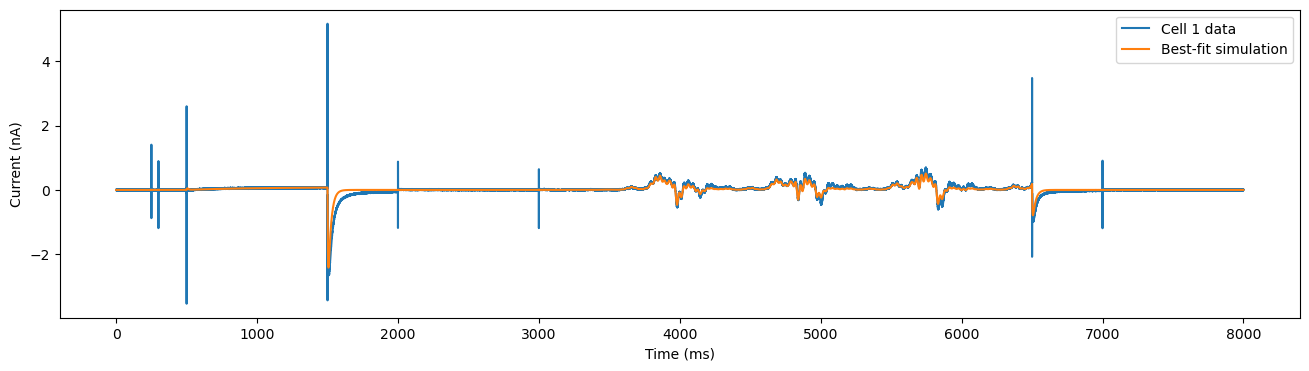

In [28]:
# Show the data for cell 1, and superimpose a simulation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(log.time(), log['current'], label='Cell 1 data')
ax.plot(d.time(), d['ikr.IKr'], label='Best-fit simulation')
ax.legend()
plt.show()

Finally, we can plot the residuals:

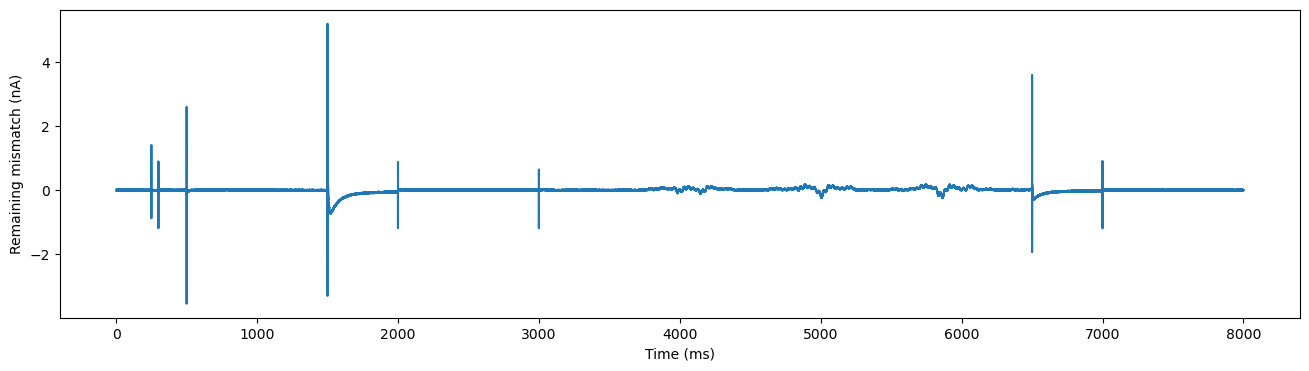

In [29]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Remaining mismatch (nA)')
ax.plot(log.time(), log['current'] - d['ikr.IKr'])
plt.show()

Clearly, this is not an iid normal noise signal.

### Interpreting MCMC results

So what does it mean when we explore a fit to data with UQ methods?

Using for example MCMC to calculate the probablity that the data was generated by the sum of a deterministic model (with an imperfect best-fit as shown above) and a stochastic iid noise model, **will** let us confirm that a given set of parameters is more likely than its neighbours.
Similarly, if we have two similar methods, and one of them provides tighter confidence intervals than the other (defined in the same imperfect way), then we **can** conclude that one method provides more certain estimates.

However, the **absolute values** returned **will not** be informative, because they are the answer to the question: _how likely is it that the residuals shown above were generated by a stochastic iid process_.
To which the answer is: very unlikely.
Similarly, the absolute widths of confidence intervals determined in the presence of model discrepancy are not necessarily informative.

Given that biological experiments provide very limited control over experimental parameters (i.e. native processes going on in the cell), and that models are _by definition_ simplifications, model discrepancy is not going anywhere soon.
Methods to perform and interpret UQ in the presence of model discrepancy are an active topic of research, and will likely remain so for some time to come.